## 12-7. Project: 멋진 챗봇 만들기
#### 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
#!pip install --upgrade gensim==3.8.3

In [1]:
import numpy 
import pandas 
import tensorflow 
import nltk
import gensim

print(numpy.__version__)
print(pandas.__version__)
print(tensorflow.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os,copy,time
import random
import math
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


In [3]:
# random sed 고정
seed = 119
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

지난 노드에서 **챗봇과 번역기는 같은 집안**이라고 했던 말을 기억하시나요?
앞서 배운 Seq2seq번역기와 Transfomer번역기에 적용할 수도 있겠지만, 이번 노드에서 배운 번역기 성능 측정법을 챗봇에도 적용해 봅시다. 배운 지식을 다양하게 활용할 수 있는 것도 중요한 능력이겠죠. 이번 프로젝트를 통해서 챗봇과 번역기가 같은 집안인지 확인해 보세요!

#### Step 1. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

* [songys/Chatbot_data](https://github.com/songys/Chatbot_data)

In [4]:
import pandas as pd

path_to_dataset = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv'
#!ls '/aiffel/aiffel/transformer_chatbot/data'
data = pd.read_csv(path_to_dataset)
print(data.shape, data.head(3), data.tail(3), data.columns)

# 데이터 Nan 여부체크: Nan 없슴
print("data.isnull().sum()", data.isnull().sum())

# questions, answers, label 로 분리
questions = data['Q'].values.tolist()
answers = data['A'].values.tolist()

# questions, answers 쌍(pair)만 별도 df
convers_pair_series = data['Q'] + '    ' + data['A']
print("convers_pair_series", convers_pair_series.shape, convers_pair_series.head())
print("결측치여부체크:", convers_pair_series.isnull().sum())

print("questions",len(questions), questions[:5])
print("answers",len(answers), answers[:5])
print("convers_pair_series",convers_pair_series.shape, convers_pair_series.head(5))

(11823, 3)               Q            A  label
0        12시 땡!   하루가 또 가네요.      0
1   1지망 학교 떨어졌어    위로해 드립니다.      0
2  3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0                              Q                         A  label
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2 Index(['Q', 'A', 'label'], dtype='object')
data.isnull().sum() Q        0
A        0
label    0
dtype: int64
convers_pair_series (11823,) 0              12시 땡!    하루가 또 가네요.
1          1지망 학교 떨어졌어    위로해 드립니다.
2       3박4일 놀러가고 싶다    여행은 언제나 좋죠.
3    3박4일 정도 놀러가고 싶다    여행은 언제나 좋죠.
4             PPL 심하네    눈살이 찌푸려지죠.
dtype: object
결측치여부체크: 0
questions 11823 ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
answers 11823 ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']
convers_pair_series (11823,) 0              12시 땡!    하루가 또 가네요.
1      

#### Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

영문자의 경우, **모두 소문자로 변환**합니다.    
영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 **정규식을 활용하여 모두 제거**합니다.    
문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [5]:
def preprocess_sentence(sentence): 
    sentence = sentence.lower().strip()
    sentence = sentence.replace("\.{2,30}"," ") 
    sentence = sentence.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  
    sentence = sentence.lower().strip()             
    return sentence

#### Step 3. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. **소스 문장 데이터와 타겟 문장 데이터**를 입력으로 받습니다.    
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 **정제하고, 토큰화**합니다.      
3. 토큰화는 **전달받은 토크나이즈 함수**를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.        
4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.    
8. **중복되는 문장은 데이터에서 제외**합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!   
구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.   


**build_corpus() 함수를 구현**

In [6]:
from konlpy.tag import Mecab 

tokenizer = Mecab()

def build_corpus(src, tgt, tokenizer, maxlen= 100):
    
    que_corpus = []
    ans_corpus = []
    
    # 중복문장제거: 튜플을 str로 전환,한개 문장내 src vs tgt는 공백4칸으로 구분, 문장별 구분은 '\n'으로 구분
    cleaned_corpus = [line[0] + ' '*4 + line[1] +'\n' for line in list(set(zip(src,tgt)))]
    print("cleaned_corpus",cleaned_corpus[:2], len(cleaned_corpus))     
    
    for i, pair in enumerate(cleaned_corpus):
        
        # pair 분리
        src_sentence = pair.split(' '*4)[0]
        tgt_sentence = pair.split(' '*4)[1]
        
        # 전처리
        src_sentence = preprocess_sentence(src_sentence)
        tgt_sentence = preprocess_sentence(tgt_sentence)

        # 형태소분석기로 단어 토큰화
        src_token = tokenizer.morphs(src_sentence) 
        tgt_token = tokenizer.morphs(tgt_sentence) 
        
        # maxlen 이하 단어갖은 문장만 append
        if len(src_token) <= maxlen and len(tgt_token) <= maxlen:
            que_corpus.append(src_token)
            ans_corpus.append(tgt_token)
        """
        if maxlen !=None and len(src_token) <= maxlen and len(tgt_token) <= maxlen:
            que_corpus.append(src_token)
            ans_corpus.append(tgt_token)
        else:
            que_corpus.append(src_token)
            ans_corpus.append(tgt_token)
        """    
    return que_corpus , ans_corpus

## 임의의 maxlen 으로 1차 토큰화진행 
que_corpus_noMax , ans_corpus_noMax = build_corpus(questions, answers, tokenizer, maxlen=100)        
        
print("que_corpus_noMax",que_corpus_noMax[:5], len(que_corpus_noMax))  
print("ans_corpus_noMax",ans_corpus_noMax[:5], len(ans_corpus_noMax))  
    

cleaned_corpus ['내일 기대하게 되네    좋은 일이 생길 거예요.\n', '고시원에서 나가고 싶어    더 좋은 곳에서 살 수 있을 거예요.\n'] 11750
que_corpus_noMax [['내일', '기대', '하', '게', '되', '네'], ['고시원', '에서', '나가', '고', '싶', '어'], ['무서운', '주말'], ['반', '배정', '부터', '올해', '끝', '났', '다', '.'], ['자꾸', '지각', '하', '네']] 11750
ans_corpus_noMax [['좋', '은', '일', '이', '생길', '거', '예요', '.'], ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.'], ['즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.'], ['1', '년', '힘내', '요', '.'], ['더', '일찍', '일어나', '세요', '.']] 11750


**max_length 설정**

questions 길이 평균, 표준편차, 최대,최소:  7.037276595744681 3.5226159627991147 32 1
answers 길이 평균, 표준편차, 최대,최소:  8.377191489361703 3.574356508896885 40 1
maxlen 14.804206514249191


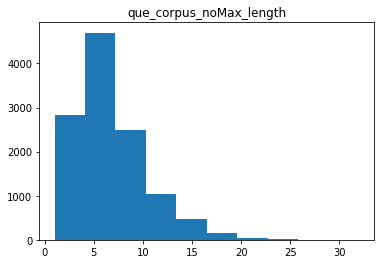

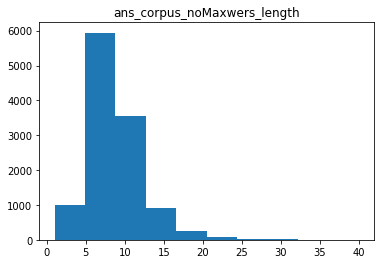

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# length list
lenq = [len(x) for x in que_corpus_noMax]
lena = [len(x) for x in ans_corpus_noMax]

# 데이터 길이 분포 파악
max_length_q = np.max(lenq)
min_length_q = np.min(lenq)
mean_length_q = np.mean(lenq)
std_length_q = np.std(lenq)
print("questions 길이 평균, 표준편차, 최대,최소: ", mean_length_q, std_length_q, max_length_q, min_length_q)

max_length_a = np.max(lena)
min_length_a = np.min(lena)
mean_length_a = np.mean(lena)
std_length_a = np.std(lena)
print("answers 길이 평균, 표준편차, 최대,최소: ", mean_length_a, std_length_a, max_length_a, min_length_a)

# maxlen 계산 공식: mean + 2*std 기준으로, 분포도를 보고서, 재량껏 조정
maxlen = (mean_length_q + mean_length_a)/2 + 2*((std_length_q + std_length_a)/2)
print("maxlen", maxlen)

# 분포를 히스토그램으로 보기 plot
plt.hist(lenq)
plt.title("que_corpus_noMax_length")
plt.show()

plt.hist(lena)
plt.title("ans_corpus_noMaxwers_length")
plt.show()


**max_length 설정: 15개**   
question, answer 공히 평균 7.5 내외, 표준편차 3.5내외, 최대길이는 각 32개, 40개인데,
max 산정에는 공식에의한 14.8 및 분포도형태상 15개이면 충분할 것으로 판단됨

**maxlen == 15 로 2차 토큰화진행**

In [8]:
## maxlen==15,  2차 토큰화진행 
que_corpus , ans_corpus = build_corpus(questions, answers, tokenizer, maxlen=15)        
        
print("que_corpus",que_corpus[:5], len(que_corpus))  
print("ans_corpus",ans_corpus[:5], len(ans_corpus))  

cleaned_corpus ['내일 기대하게 되네    좋은 일이 생길 거예요.\n', '고시원에서 나가고 싶어    더 좋은 곳에서 살 수 있을 거예요.\n'] 11750
que_corpus [['내일', '기대', '하', '게', '되', '네'], ['고시원', '에서', '나가', '고', '싶', '어'], ['무서운', '주말'], ['반', '배정', '부터', '올해', '끝', '났', '다', '.'], ['자꾸', '지각', '하', '네']] 10960
ans_corpus [['좋', '은', '일', '이', '생길', '거', '예요', '.'], ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.'], ['즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.'], ['1', '년', '힘내', '요', '.'], ['더', '일찍', '일어나', '세요', '.']] 10960


#### Step 4. Augmentation
우리에게 주어진 데이터는 **1만 개가량으로 적은 편**에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? **Lexical Substitution을 실제로 적용**해 보도록 하겠습니다.

아래 링크를 참고하여 **한국어로 사전 훈련된 Embedding 모델을 다운로드**합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

* [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 데이터를 **Augmentation** 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 **전체 데이터가 원래의 3배가량**으로 늘어나도록 합니다.

**pre_trained word2vec 다운로드후 모델 load:** gensim 3.8.x에서만 가능하여, 원래의 4.1.2에서 3.8.3으로 down grade했슴

In [9]:
wv_kor = gensim.models.Word2Vec.load('/aiffel/aiffel/transformer_chatbot/model/ko.bin') #'./model/ko.bin')
a = wv_kor.wv.most_similar("강아지")
print(a)
# import gensim.downloader as api: wv = api.load('~/model/ko.bin') ==> 모델 로드 않됨

[('고양이', 0.7290452718734741), ('거위', 0.7185635566711426), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.6750352382659912), ('아빠', 0.6729634404182434), ('목걸이', 0.6512460708618164)]


**데이터 Augmentation: lexical_sub() 함수 및 data_augmentation 및  Make_CleanAugmenetDataSet_and_Remove_Nan함수 구현 및 사용**

In [10]:
# Lexical Substitution 구현하기
def lexical_sub(token_sentence, word2vec):
    #res = ""
    #toks = token_sentence
    res = []
    
    try:  
        _from = random.choice(token_sentence)
        _to = word2vec.most_similar(_from)[0][0]   # 유사도점수순으로 (단어,유사도점수) 튜플중 제일 높은 점수쌍중 단어만 고름 
               
    except:   # 단어장에 없는 단어
        return None

    for tok in token_sentence:
        #if tok is _from: res += _to + " "  #원래코드
        #else: res += tok + " "             #원래코드
        if tok is _from: res.append(_to)
        else: res.append(tok)
    #print("res",res)        
    return res

In [11]:
# 텍스트 데이터 augmentation 함수 구현
def data_augmentation(corpus, wv):
    new_corpus = []
    count = 0
    for old_src in tqdm(corpus):
        new_src = lexical_sub(old_src, wv_kor)

        count += 1
        if count < 5:
            print("old_src", old_src, "new_src", new_src)
        
        # None있는 곳에 np.nan 대체입력: pd.isna()로 쉽게 제거가능
        if new_src is None:
            new_corpus.append(np.nan)    
        else:
            new_corpus.append(new_src)  
        # Augmentation이 없더라도 원본 문장을 포함시킵니다
        new_corpus.append(old_src)
    print(new_corpus[:10])
    return new_corpus
   
new_que_corpus = data_augmentation(que_corpus, wv_kor)
new_ans_corpus = data_augmentation(ans_corpus, wv_kor)

# new_que_corpus,new_ans_corpus 데이터를  각각 new_corpus, old_corpus 병렬쌍으로 전환
new_que_corpus = np.array(new_que_corpus,dtype=object).reshape(-1,2).tolist()
new_ans_corpus = np.array(new_ans_corpus,dtype=object).reshape(-1,2).tolist()

# 병렬쌍 여부 체크: OK
print("new_que_corpus[:10]",len(new_que_corpus),new_que_corpus[:10])
print("new_ans_corpus[:10]",len(new_ans_corpus),new_ans_corpus[:10])  

  0%|          | 0/10960 [00:00<?, ?it/s]

/tmp/ipykernel_531/1941403359.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]   # 유사도점수순으로 (단어,유사도점수) 튜플중 제일 높은 점수쌍중 단어만 고름


old_src ['내일', '기대', '하', '게', '되', '네'] new_src ['내일', '기대', '시키', '게', '되', '네']
old_src ['고시원', '에서', '나가', '고', '싶', '어'] new_src ['고시원', '오세아니아', '나가', '고', '싶', '어']
old_src ['무서운', '주말'] new_src ['무서운', '토요일']
old_src ['반', '배정', '부터', '올해', '끝', '났', '다', '.'] new_src ['반', '할당', '부터', '올해', '끝', '났', '다', '.']
[['내일', '기대', '시키', '게', '되', '네'], ['내일', '기대', '하', '게', '되', '네'], ['고시원', '오세아니아', '나가', '고', '싶', '어'], ['고시원', '에서', '나가', '고', '싶', '어'], ['무서운', '토요일'], ['무서운', '주말'], ['반', '할당', '부터', '올해', '끝', '났', '다', '.'], ['반', '배정', '부터', '올해', '끝', '났', '다', '.'], ['그럼', '지각', '하', '네'], ['자꾸', '지각', '하', '네']]


  0%|          | 0/10960 [00:00<?, ?it/s]

old_src ['좋', '은', '일', '이', '생길', '거', '예요', '.'] new_src ['좋', '은', '일', '이', '생길', '것', '예요', '.']
old_src ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.'] new_src ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '것', '예요', '.']
old_src ['즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.'] new_src ['즐거운', '주말', '그러', '되', '시', '길', '바랄게요', '.']
old_src ['1', '년', '힘내', '요', '.'] new_src ['1', '년', '힘내', '요', '는데']
[['좋', '은', '일', '이', '생길', '것', '예요', '.'], ['좋', '은', '일', '이', '생길', '거', '예요', '.'], ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '것', '예요', '.'], ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.'], ['즐거운', '주말', '그러', '되', '시', '길', '바랄게요', '.'], ['즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.'], ['1', '년', '힘내', '요', '는데'], ['1', '년', '힘내', '요', '.'], ['더', '빨리', '일어나', '세요', '.'], ['더', '일찍', '일어나', '세요', '.']]
new_que_corpus[:10] 10960 [[['내일', '기대', '시키', '게', '되', '네'], ['내일', '기대', '하', '게', '되', '네']], [['고시원', '오세아니아', '나가', '고', '싶', '어'], ['고

**augmentation data pair(쌍)정렬및 통합데이터완성: 원본데이터pair + que원본및ans증강 +  que증강및ans원본 + que증강및ans증강**    
원본 questions, answers 각각 11750개 문장 ===> 중복제거,15단어이상제거등으로 10960개==>  증강 완성 questions, answers 각각 35347개 문장을 만들어서 약 3.4배정도의 데이터를 생성.

In [12]:
# Augmentation data pair(쌍)정렬및 통합데이터 완성함수 구현: 문장내의 np.nan 제거 코드 포함 OK
def Make_CleanAugmenetDataSet_and_Remove_Nan(augment1, augment2):
    
    df = pd.DataFrame({'nan_chk1':np.array(augment1)[:,0],'nan_chk2':np.array(augment2)[:,0],"augment1":augment1,
                 "augment2":augment2})
    print("shape",df.shape)   
    print("Nan있는 문장개수", df.isnull().sum())
    # nan있는 문장 통합제거: 
    df.dropna(axis=0, inplace=True)
    print("Nan 제거후 문장개수", df.isnull().sum())
    print("shape",df.shape)
    
    # np.array 전환
    augment1_np= np.array(augment1, dtype=object)
    augment2_np= np.array(augment2, dtype=object)
    augment1_without_nan= np.array(df['augment1'].values.tolist())
    augment2_without_nan= np.array(df['augment2'].values.tolist())
    # data별 pair 순서대로 문장통합 및 완성: 원본데이터pair + que원본및ans증강 +  que증강및ans원본 + que증강및ans증강
    total_augment1_clean = np.concatenate(
        [augment1_np[:,1],augment1_without_nan[:,0],augment1_without_nan[:,1],augment1_without_nan[:,0]], axis=0)    
    total_augment2_clean = np.concatenate(
        [augment2_np[:,1],augment2_without_nan[:,1],augment2_without_nan[:,0],augment2_without_nan[:,0]], axis=0)    
           
    # numpy.array ==> list 재전환
    total_augment1_clean = total_augment1_clean.tolist()
    total_augment2_clean = total_augment2_clean.tolist()
    print("통합된 clean Augment data 최종 문장개수","total_augment1_clean", len(total_augment1_clean),
          "total_augment2_clean", len(total_augment1_clean))
    return  total_augment1_clean,total_augment2_clean
       
# 완성된 Augment Data Set
new_que_corpus_cleaned,new_ans_corpus_cleaned = Make_CleanAugmenetDataSet_and_Remove_Nan(new_que_corpus,new_ans_corpus)
print("new_que_corpus_cleaned",len(new_que_corpus_cleaned),new_que_corpus_cleaned[:5])
print("new_ans_corpus_cleaned",len(new_ans_corpus_cleaned),new_ans_corpus_cleaned[:5])

## nan 존재여부 재확인: 없슴 
df = pd.DataFrame({"augment1":new_que_corpus_cleaned,
                 "augment2":new_ans_corpus_cleaned})
print("shape",df.shape)   
print("Nan있는 문장개수", df.isnull().sum())
# nan있는 문장 통합제거: np.where(pd.isna())
df.dropna(axis=0, inplace=True)
print("Nan 제거후 Nan 잔존 여부", df.isnull().sum())
print("shape",df.shape)

shape (10960, 4)
Nan있는 문장개수 nan_chk1    1715
nan_chk2    1312
augment1       0
augment2       0
dtype: int64
Nan 제거후 문장개수 nan_chk1    0
nan_chk2    0
augment1    0
augment2    0
dtype: int64
shape (8129, 4)
통합된 clean Augment data 최종 문장개수 total_augment1_clean 35347 total_augment2_clean 35347
new_que_corpus_cleaned 35347 [['내일', '기대', '하', '게', '되', '네'], ['고시원', '에서', '나가', '고', '싶', '어'], ['무서운', '주말'], ['반', '배정', '부터', '올해', '끝', '났', '다', '.'], ['자꾸', '지각', '하', '네']]
new_ans_corpus_cleaned 35347 [['좋', '은', '일', '이', '생길', '거', '예요', '.'], ['더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.'], ['즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.'], ['1', '년', '힘내', '요', '.'], ['더', '일찍', '일어나', '세요', '.']]
shape (35347, 2)
Nan있는 문장개수 augment1    0
augment2    0
dtype: int64
Nan 제거후 Nan 잔존 여부 augment1    0
augment2    0
dtype: int64
shape (35347, 2)


/tmp/ipykernel_531/2083757178.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame({'nan_chk1':np.array(augment1)[:,0],'nan_chk2':np.array(augment2)[:,0],"augment1":augment1,
/tmp/ipykernel_531/2083757178.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augment1_without_nan= np.array(df['augment1'].values.tolist())
/tmp/ipykernel_531/2083757178.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

In [13]:
"""
i = 8177
idx= i  #10960#8193
print(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])
idx= 10960 + i
print(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])
idx= 10960 + 8178+ i
print(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])
idx= 10961 + 8178*2 + i-1
print(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])
"""

'\ni = 8177\nidx= i  #10960#8193\nprint(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])\nidx= 10960 + i\nprint(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])\nidx= 10960 + 8178+ i\nprint(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])\nidx= 10961 + 8178*2 + i-1\nprint(new_que_corpus_cleaned[idx],new_ans_corpus_cleaned[idx])\n'

#### Step 5. 데이터 벡터화
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!    
    
챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 **소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것** 이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 **전체 데이터에 대한 단어 사전을 구축하고 벡터화**하여 enc_train 과 dec_train 을 얻으세요!

In [14]:
# ansers 데이터에 "<start>","<end>" 추가
new_ans_corpus_cleaned_add=[]
for tok_sen in new_ans_corpus_cleaned:
    #print(tok_sen)
    tok_sen1= ["<start>"] + tok_sen + ["<end>"]
    #print(tok_sen1)
    new_ans_corpus_cleaned_add.append(tok_sen1)
    
print("new_ans_corpus_cleaned_add", len(new_ans_corpus_cleaned_add), new_ans_corpus_cleaned_add[:3])    

new_ans_corpus_cleaned_add 35347 [['<start>', '좋', '은', '일', '이', '생길', '거', '예요', '.', '<end>'], ['<start>', '더', '좋', '은', '곳', '에서', '살', '수', '있', '을', '거', '예요', '.', '<end>'], ['<start>', '즐거운', '주말', '이', '되', '시', '길', '바랄게요', '.', '<end>']]


In [15]:
#### 정수인덱스 토큰화하기, 보정처리 및 padding
def tokenize(corpus,maxlen=20, que_token= False): 
    ## 정수인덱스 토큰화
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token= '<unk>')  #lower 또하면 'BOS''EOS'도 소문자됨      
    tokenizer.fit_on_texts(corpus)
    #[주의!!] 보정처리할 경우에는 texts_to_sequences(corpus)를 보정처리후 padding전에  해야함
    
    ## 보정처리, texts_to_sequences 및 패딩: 
    print("보정전 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    if que_token == True:
        # quetions 보정처리
        print("보정전 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k <=10])
        
        tokenizer.index_word = {k + 3: v for k,v in tokenizer.index_word.items()}
        tokenizer.index_word.update({0:'<pad>',1:'', 2:'', 3:'<unk>'}) 
        # 중복있을 경우 제거: '<unk>','',''
        tokenizer.index_word={k:v for k,v in tokenizer.index_word.items() if (k in [0,3]) or  v not in ['<unk>','','']}
       
        tokenizer.word_index = {v: k for k,v in tokenizer.index_word.items()}
        print("tokenizer.index_word",tokenizer.index_word[0],tokenizer.index_word[3],tokenizer.index_word[5])
        print("tokenizer.word_index",tokenizer.word_index['<pad>'],tokenizer.word_index['<unk>'])
               
        # 보정처리완료후texts_to_sequences(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') #maxlen = maxlen,#maxlen = 50,
        
    else:
        # ansers 보정처리
        print("보정전 tokenizer.index_word[0~10]",[(k,v) for i,(k,v) in enumerate(tokenizer.index_word.items()) if i <=20])
        
        tokenizer.index_word = {k + 3: v for k,v in tokenizer.index_word.items()}
        tokenizer.index_word.update({0:'<pad>',1: '<start>', 2:'<end>', 3:'<unk>'}) 
        # 중복있을 경우 제거: '<unk>','<start>','<end>
        tokenizer.index_word={k:v for k,v in tokenizer.index_word.items() if k < 4 or  v not in ['<unk>','<start>','<end>']}
        
        tokenizer.word_index = {v: k for k,v in tokenizer.index_word.items()}
        print("tokenizer.index_word",tokenizer.index_word[0],tokenizer.index_word[1],tokenizer.index_word[2],
             tokenizer.index_word[3])
        print("tokenizer.word_index",tokenizer.word_index['<pad>'],tokenizer.word_index['<start>'],
              tokenizer.word_index['<end>'],tokenizer.word_index['<unk>'])    
        print("보정후 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k<=20])
        
        # 보정처리완료후texts_to_sequences(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') #maxlen = maxlen,maxlen
        
    
    print("보정후 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    
    return tensor, tokenizer

# 정수인덱스 토큰화및 패딩처리를 완료하여 학습용 데이터를 완성. 
enc_tensor, enc_tokenizer = tokenize(new_que_corpus_cleaned, maxlen= 20, que_token= True)
dec_tensor, dec_tokenizer = tokenize(new_ans_corpus_cleaned_add, maxlen= 20 )

print("enc_tensor", len(enc_tensor), enc_tensor[:2],enc_tensor[-2:])
print("dec_tensor", len(dec_tensor), dec_tensor[:2],dec_tensor[-2:])

# train_data  permutation(shuffle): train_data == numpy.array
indices_permutation = np.random.permutation(len(enc_tensor))

enc_tensor = enc_tensor[indices_permutation]
dec_tensor = dec_tensor[indices_permutation]
print("enc_tensor", len(enc_tensor), enc_tensor[:2],enc_tensor[-2:])
print("dec_tensor", len(dec_tensor), dec_tensor[:2],dec_tensor[-2:])

# train_data  valid data 분리:  0.9 
splitlen = int(len(enc_tensor)*0.9)

enc_train = enc_tensor[:splitlen]
enc_val =  enc_tensor[splitlen:]
print("enc_train, enc_val", len(enc_train), len(enc_val))

dec_train = dec_tensor[:splitlen]
dec_val =  dec_tensor[splitlen:]
print("dec_train, dec_val", len(dec_train), len(dec_val))



보정전 단어사전 길이: 5969 5969
보정전 tokenizer.index_word[0~10] [(1, '<unk>'), (2, '는'), (3, '이'), (4, '.'), (5, '하'), (6, '어'), (7, '가'), (8, '?'), (9, '고'), (10, '아')]
tokenizer.index_word <pad> <unk> 는
tokenizer.word_index 0 3
보정후 단어사전 길이: 5970 5970
보정전 단어사전 길이: 4306 4306
보정전 tokenizer.index_word[0~10] [(1, '<unk>'), (2, '<start>'), (3, '<end>'), (4, '.'), (5, '세요'), (6, '이'), (7, '하'), (8, '을'), (9, '는'), (10, '보'), (11, '거'), (12, '은'), (13, '있'), (14, '해'), (15, '예요'), (16, '좋'), (17, '가'), (18, '도'), (19, '지'), (20, '어요'), (21, '죠')]
tokenizer.index_word <pad> <start> <end> <unk>
tokenizer.word_index 0 1 2 3
보정후 tokenizer.index_word[0~10] [(7, '.'), (8, '세요'), (9, '이'), (10, '하'), (11, '을'), (12, '는'), (13, '보'), (14, '거'), (15, '은'), (16, '있'), (17, '해'), (18, '예요'), (19, '좋'), (20, '가'), (0, '<pad>'), (1, '<start>'), (2, '<end>'), (3, '<unk>')]
보정후 단어사전 길이: 4307 4307
enc_tensor 35347 [[ 231  538    8   28   48   19    0    0    0    0    0    0    0    0
     0]
 [1531   66  286   12   

In [16]:
# length list
lenq = [len(x) for x in enc_train]
lena = [len(x) for x in dec_train]

# 데이터 길이 분포 파악
max_length_a = np.max(lena)
min_length_a = np.min(lena)
mean_length_a = np.mean(lena)
std_length_a = np.std(lena)
print("answers 길이 평균, 표준편차, 최대,최소: ", mean_length_a, std_length_a, max_length_a, min_length_a)

answers 길이 평균, 표준편차, 최대,최소:  17.0 0.0 17 17


#### max_length 재설정: 15개 --> 17개로 증가 반영
step2 에서 일정길이 문장이상 제외위해 설정한 maxlen 15에서, step5에서 'start', 'end' 토큰추가등 보정처리후
padding 작업결과 maxlen 증가됨

In [17]:
maxlen = 17
print("maxlen", maxlen)

maxlen 17


#### Step 6. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! **가장 멋진 답변과 모델의 하이퍼파라미터를 제출**하시면 됩니다.

```
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10
```
 

#### 모델구성

In [18]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    print(sinusoid_table)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

#print(positional_encoding(10, 5))


In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads  
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        
    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
          

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
       
        return out, attention_weights


In [20]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [22]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout) 
                
    def call(self, x, enc_out, causality_mask, padding_mask):
        
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)  # padding_mask == dec_mask == tf.maximum(dec_mask,dec_causal_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)  # causal_mask==tf.maxi(enc_mas,dec_enc_causal_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn


In [23]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


In [25]:
import tensorflow.keras.backend as K

class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        #self.d_model = tf.cast(d_model, tf.float32)  ==> float로 할 경우 dimension 오류발생됨
        self.d_model = d_model   
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, self.d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)   # int(n_heads)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)   # int(n_heads)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """      
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(tf.cast(d_model, tf.float32)) #self.d_model)   # int ???  self.d_model
       
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)
        
        return out
    
        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
 

In [26]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    #print("enc_mask",enc_mask.shape,enc_mask,"dec_enc_causality_mask",dec_enc_causality_mask.shape,dec_enc_causality_mask)
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)
    #print("dec_enc_mask",dec_enc_mask.shape,dec_enc_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    #print("dec_mask",dec_mask.shape, dec_mask,"dec_causality_mask",dec_causality_mask.shape,dec_causality_mask)
    return enc_mask, dec_enc_mask, dec_mask


In [27]:
##  LearningRateScheduler 클래스 함수정의
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

#learning_rate = LearningRateScheduler(d_model = 512, warmup_steps = 4000)
#optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [28]:
#Hyperparameters
n_layers= 1
d_model= 368
n_heads= 8
d_ff= 1024
pos_len = 17
dropout= 0.3   
src_vocab_size = len(enc_tokenizer.word_index) #6167
tgt_vocab_size = len(dec_tokenizer.word_index) #7187
shared=True

#Training Parameters
warmup_steps = 1000
BATCH_SIZE = 64
EPOCHS = 10 


# 트랜스포머 모델설정
transformer = Transformer(n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=dropout,
                 shared=True)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.75282507e-01 9.51175969e-01 ... 1.07797502e-04
  1.05133018e-04 1.02534393e-04]
 [2.00000000e+00 1.95056501e+00 1.90235194e+00 ... 2.15595003e-04
  2.10266035e-04 2.05068786e-04]
 ...
 [1.40000000e+01 1.36539551e+01 1.33164636e+01 ... 1.50916502e-03
  1.47186225e-03 1.43548150e-03]
 [1.50000000e+01 1.46292376e+01 1.42676395e+01 ... 1.61696252e-03
  1.57699527e-03 1.53801590e-03]
 [1.60000000e+01 1.56045201e+01 1.52188155e+01 ... 1.72476003e-03
  1.68212828e-03 1.64055029e-03]]


In [29]:
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    #[주의} real data는 transformer model 내에서는 마스크가 씌워지는 절차없으니,여기서 씌움,모델내에서는 enc_train,dec_train 만 씌움
    mask = tf.math.logical_not(tf.math.equal(real, 0))   # 여기선 마스크씌울 부분이 0 이됨, "곱해주는 마스크"라서, 0이됨 
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask         # 여기선 마스크씌울 부분이 0 이므로, 곱해주어야 패딩부분이 0이되어 무시됨,즉, loss의 합계에서 제외됨 

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [31]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    variables = model.encoder.trainable_variables + model.decoder.trainable_variables 
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return loss, enc_attns, dec_attns, dec_enc_attns
   

In [32]:
# Valid Step 함수 정의

@tf.function()
def valid_step(src, tgt, model):
    gold = tgt[:, 1:]
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask, training=False)
    val_loss = loss_function(gold, predictions[:, :-1])
    
    return val_loss    #, enc_attns, dec_attns, dec_enc_attns
   

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.82171889e-01 9.64661620e-01 ... 1.05544960e-04
  1.03663293e-04 1.01815172e-04]
 [2.00000000e+00 1.96434378e+00 1.92932324e+00 ... 2.11089920e-04
  2.07326586e-04 2.03630344e-04]
 ...
 [1.40000000e+01 1.37504064e+01 1.35052627e+01 ... 1.47762944e-03
  1.45128610e-03 1.42541241e-03]
 [1.50000000e+01 1.47325783e+01 1.44699243e+01 ... 1.58317440e-03
  1.55494939e-03 1.52722758e-03]
 [1.60000000e+01 1.57147502e+01 1.54345859e+01 ... 1.68871936e-03
  1.65861269e-03 1.62904275e-03]]
i 0 param 30
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.82171889e-01 9.64661620e-01 ... 1.05544960e-04
  1.03663293e-04 1.01815172e-04]
 [2.00000000e+00 1.96434378e+00 1.92932324e+00 ... 2.11089920e-04
  2.07326586e-04 2.03630344e-04]
 ...
 [1.40000000e+01 1.37504064e+01 1.35052627e+01 ... 1.47762944e-03
  1.45128610e-03 1.

  0%|          | 0/498 [00:00<?, ?it/s]

epoch 0 batch 0 idx 0 batch_loss1 9.1367
epoch 0 batch 250 idx 16000 batch_loss1 5.0468
val_batch 0
val_batch 25
val_batch 50
epoch 0 epoch_val_loss1 4.0217
Epoch 0 Epoch_변화시_학습율적용_step >> count_step 495 lr 0.0019566594
epoch_loss 4.4156 epoch_val_loss 4.0217


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 1 batch 0 idx 0 batch_loss1 4.0795
epoch 1 batch 250 idx 16000 batch_loss1 3.2013
val_batch 0
val_batch 25
val_batch 50
epoch 1 epoch_val_loss1 2.4796
Epoch 1 Epoch_변화시_학습율적용_step >> count_step 990 lr 0.0014045831
epoch_loss 2.8226 epoch_val_loss 2.4796


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 2 batch 0 idx 0 batch_loss1 2.2695
epoch 2 batch 250 idx 16000 batch_loss1 1.8152
val_batch 0
val_batch 25
val_batch 50
epoch 2 epoch_val_loss1 1.711
Epoch 2 Epoch_변화시_학습율적용_step >> count_step 1485 lr 0.0011468373
epoch_loss 1.593 epoch_val_loss 1.711


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 3 batch 0 idx 0 batch_loss1 1.2439
epoch 3 batch 250 idx 16000 batch_loss1 1.0734
val_batch 0
val_batch 25
val_batch 50
epoch 3 epoch_val_loss1 1.343
Epoch 3 Epoch_변화시_학습율적용_step >> count_step 1980 lr 0.0009931902
epoch_loss 0.9852 epoch_val_loss 1.343


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 4 batch 0 idx 0 batch_loss1 0.9153
epoch 4 batch 250 idx 16000 batch_loss1 0.7591
val_batch 0
val_batch 25
val_batch 50
epoch 4 epoch_val_loss1 1.1829
Epoch 4 Epoch_변화시_학습율적용_step >> count_step 2475 lr 0.0008883363
epoch_loss 0.7175 epoch_val_loss 1.1829


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 5 batch 0 idx 0 batch_loss1 0.66
epoch 5 batch 250 idx 16000 batch_loss1 0.5978
val_batch 0
val_batch 25
val_batch 50
epoch 5 epoch_val_loss1 1.0904
Epoch 5 Epoch_변화시_학습율적용_step >> count_step 2970 lr 0.0008109364
epoch_loss 0.5724 epoch_val_loss 1.0904


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 6 batch 0 idx 0 batch_loss1 0.6004
epoch 6 batch 250 idx 16000 batch_loss1 0.5089
val_batch 0
val_batch 25
val_batch 50
epoch 6 epoch_val_loss1 1.0468
Epoch 6 Epoch_변화시_학습율적용_step >> count_step 3465 lr 0.0007507812
epoch_loss 0.4912 epoch_val_loss 1.0468


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 7 batch 0 idx 0 batch_loss1 0.488
epoch 7 batch 250 idx 16000 batch_loss1 0.4427
val_batch 0
val_batch 25
val_batch 50
epoch 7 epoch_val_loss1 1.0185
Epoch 7 Epoch_변화시_학습율적용_step >> count_step 3960 lr 0.00070229155
epoch_loss 0.4321 epoch_val_loss 1.0185


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 8 batch 0 idx 0 batch_loss1 0.4822
epoch 8 batch 250 idx 16000 batch_loss1 0.402
val_batch 0
val_batch 25
val_batch 50
epoch 8 epoch_val_loss1 0.9791
Epoch 8 Epoch_변화시_학습율적용_step >> count_step 4455 lr 0.00066212675
epoch_loss 0.3924 epoch_val_loss 0.9791


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 9 batch 0 idx 0 batch_loss1 0.4285
epoch 9 batch 250 idx 16000 batch_loss1 0.3709
val_batch 0
val_batch 25
val_batch 50
epoch 9 epoch_val_loss1 0.9613
Epoch 9 Epoch_변화시_학습율적용_step >> count_step 4950 lr 0.0006281486
epoch_loss 0.3622 epoch_val_loss 0.9613


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 10 batch 0 idx 0 batch_loss1 0.4273
epoch 10 batch 250 idx 16000 batch_loss1 0.3415
val_batch 0
val_batch 25
val_batch 50
epoch 10 epoch_val_loss1 0.9587
Epoch 10 Epoch_변화시_학습율적용_step >> count_step 5445 lr 0.0005989162
epoch_loss 0.3346 epoch_val_loss 0.9587


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 11 batch 0 idx 0 batch_loss1 0.3767
epoch 11 batch 250 idx 16000 batch_loss1 0.3176
val_batch 0
val_batch 25
val_batch 50
epoch 11 epoch_val_loss1 0.9436
Epoch 11 Epoch_변화시_학습율적용_step >> count_step 5940 lr 0.0005734186
epoch_loss 0.3115 epoch_val_loss 0.9436


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 12 batch 0 idx 0 batch_loss1 0.3759
epoch 12 batch 250 idx 16000 batch_loss1 0.292
val_batch 0
val_batch 25
val_batch 50
epoch 12 epoch_val_loss1 0.932
Epoch 12 Epoch_변화시_학습율적용_step >> count_step 6435 lr 0.00055092276
epoch_loss 0.2861 epoch_val_loss 0.932


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 13 batch 0 idx 0 batch_loss1 0.2959
epoch 13 batch 250 idx 16000 batch_loss1 0.2733
val_batch 0
val_batch 25
val_batch 50
epoch 13 epoch_val_loss1 0.935
Epoch 13 Epoch_변화시_학습율적용_step >> count_step 6930 lr 0.0005308825
epoch_loss 0.2683 epoch_val_loss 0.935


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 14 batch 0 idx 0 batch_loss1 0.323
epoch 14 batch 250 idx 16000 batch_loss1 0.2523
val_batch 0
val_batch 25
val_batch 50
epoch 14 epoch_val_loss1 0.9676
Epoch 14 Epoch_변화시_학습율적용_step >> count_step 7425 lr 0.0005128812
epoch_loss 0.2476 epoch_val_loss 0.9676


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 15 batch 0 idx 0 batch_loss1 0.2984
epoch 15 batch 250 idx 16000 batch_loss1 0.2344
val_batch 0
val_batch 25
val_batch 50
epoch 15 epoch_val_loss1 0.9611
Epoch 15 Epoch_변화시_학습율적용_step >> count_step 7920 lr 0.0004965951
epoch_loss 0.2327 epoch_val_loss 0.9611


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 16 batch 0 idx 0 batch_loss1 0.2948
epoch 16 batch 250 idx 16000 batch_loss1 0.222
val_batch 0
val_batch 25
val_batch 50
epoch 16 epoch_val_loss1 0.9722
Epoch 16 Epoch_변화시_학습율적용_step >> count_step 8415 lr 0.00048176802
epoch_loss 0.217 epoch_val_loss 0.9722


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 17 batch 0 idx 0 batch_loss1 0.2502
epoch 17 batch 250 idx 16000 batch_loss1 0.2057
val_batch 0
val_batch 25
val_batch 50
epoch 17 epoch_val_loss1 0.9816
Epoch 17 Epoch_변화시_학습율적용_step >> count_step 8910 lr 0.00046819434
epoch_loss 0.2011 epoch_val_loss 0.9816


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 18 batch 0 idx 0 batch_loss1 0.2194
epoch 18 batch 250 idx 16000 batch_loss1 0.1895
val_batch 0
val_batch 25
val_batch 50
epoch 18 epoch_val_loss1 1.0248
Epoch 18 Epoch_변화시_학습율적용_step >> count_step 9405 lr 0.0004557069
epoch_loss 0.1866 epoch_val_loss 1.0248


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 19 batch 0 idx 0 batch_loss1 0.1734
epoch 19 batch 250 idx 16000 batch_loss1 0.1785
val_batch 0
val_batch 25
val_batch 50
epoch 19 epoch_val_loss1 1.0024
Epoch 19 Epoch_변화시_학습율적용_step >> count_step 9900 lr 0.00044416814
epoch_loss 0.1745 epoch_val_loss 1.0024


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 20 batch 0 idx 0 batch_loss1 0.21
epoch 20 batch 250 idx 16000 batch_loss1 0.1655
val_batch 0
val_batch 25
val_batch 50
epoch 20 epoch_val_loss1 1.0201
Epoch 20 Epoch_변화시_학습율적용_step >> count_step 10395 lr 0.00043346375
epoch_loss 0.1632 epoch_val_loss 1.0201


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 21 batch 0 idx 0 batch_loss1 0.2016
epoch 21 batch 250 idx 16000 batch_loss1 0.1554
val_batch 0
val_batch 25
val_batch 50
epoch 21 epoch_val_loss1 1.0107
Epoch 21 Epoch_변화시_학습율적용_step >> count_step 10890 lr 0.0004234977
epoch_loss 0.1532 epoch_val_loss 1.0107


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 22 batch 0 idx 0 batch_loss1 0.1308
epoch 22 batch 250 idx 16000 batch_loss1 0.1446
val_batch 0
val_batch 25
val_batch 50
epoch 22 epoch_val_loss1 1.0091
Epoch 22 Epoch_변화시_학습율적용_step >> count_step 11385 lr 0.00041418892
epoch_loss 0.1416 epoch_val_loss 1.0091


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 23 batch 0 idx 0 batch_loss1 0.1283
epoch 23 batch 250 idx 16000 batch_loss1 0.1361
val_batch 0
val_batch 25
val_batch 50
epoch 23 epoch_val_loss1 1.0061
Epoch 23 Epoch_변화시_학습율적용_step >> count_step 11880 lr 0.0004054682
epoch_loss 0.1335 epoch_val_loss 1.0061


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 24 batch 0 idx 0 batch_loss1 0.1156
epoch 24 batch 250 idx 16000 batch_loss1 0.1285
val_batch 0
val_batch 25
val_batch 50
epoch 24 epoch_val_loss1 1.0197
Epoch 24 Epoch_변화시_학습율적용_step >> count_step 12375 lr 0.00039727608
epoch_loss 0.1279 epoch_val_loss 1.0197


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 25 batch 0 idx 0 batch_loss1 0.1375
epoch 25 batch 250 idx 16000 batch_loss1 0.1232
val_batch 0
val_batch 25
val_batch 50
epoch 25 epoch_val_loss1 1.0082
Epoch 25 Epoch_변화시_학습율적용_step >> count_step 12870 lr 0.00038956126
epoch_loss 0.1206 epoch_val_loss 1.0082


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 26 batch 0 idx 0 batch_loss1 0.1409
epoch 26 batch 250 idx 16000 batch_loss1 0.1182
val_batch 0
val_batch 25
val_batch 50
epoch 26 epoch_val_loss1 1.018
Epoch 26 Epoch_변화시_학습율적용_step >> count_step 13365 lr 0.00038227907
epoch_loss 0.1176 epoch_val_loss 1.018


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 27 batch 0 idx 0 batch_loss1 0.143
epoch 27 batch 250 idx 16000 batch_loss1 0.1117
val_batch 0
val_batch 25
val_batch 50
epoch 27 epoch_val_loss1 1.0394
Epoch 27 Epoch_변화시_학습율적용_step >> count_step 13860 lr 0.0003753906
epoch_loss 0.1108 epoch_val_loss 1.0394


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 28 batch 0 idx 0 batch_loss1 0.1201
epoch 28 batch 250 idx 16000 batch_loss1 0.1068
val_batch 0
val_batch 25
val_batch 50
epoch 28 epoch_val_loss1 1.0255
Epoch 28 Epoch_변화시_학습율적용_step >> count_step 14355 lr 0.00036886157
epoch_loss 0.1068 epoch_val_loss 1.0255


  0%|          | 0/498 [00:00<?, ?it/s]

epoch 29 batch 0 idx 0 batch_loss1 0.1351
epoch 29 batch 250 idx 16000 batch_loss1 0.1019
val_batch 0
val_batch 25
val_batch 50
epoch 29 epoch_val_loss1 1.035
Epoch 29 Epoch_변화시_학습율적용_step >> count_step 14850 lr 0.00036266178
epoch_loss 0.1019 epoch_val_loss 1.035
history.keys() dict_keys(['epoch']) dict_keys(['30'])
history[hpname][f'{param}']['loss'] [4.4156, 2.8226, 1.593, 0.9852, 0.7175, 0.5724, 0.4912, 0.4321, 0.3924, 0.3622, 0.3346, 0.3115, 0.2861, 0.2683, 0.2476, 0.2327, 0.217, 0.2011, 0.1866, 0.1745, 0.1632, 0.1532, 0.1416, 0.1335, 0.1279, 0.1206, 0.1176, 0.1108, 0.1068, 0.1019]
history[hpname][f'{param}']['val_loss'] [4.0217, 2.4796, 1.711, 1.343, 1.1829, 1.0904, 1.0468, 1.0185, 0.9791, 0.9613, 0.9587, 0.9436, 0.932, 0.935, 0.9676, 0.9611, 0.9722, 0.9816, 1.0248, 1.0024, 1.0201, 1.0107, 1.0091, 1.0061, 1.0197, 1.0082, 1.018, 1.0394, 1.0255, 1.035]
history[hpname][f'{param}']['lr'] [0.0019566594, 0.0014045831, 0.0011468373, 0.0009931902, 0.0008883363, 0.0008109364, 0.0007507812

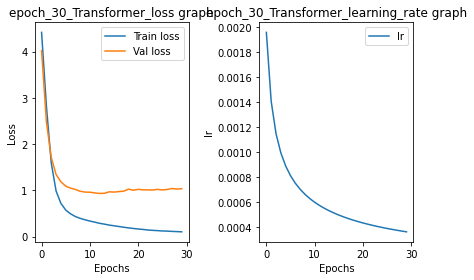

epoch_Best_val_epoch_loss [[13, 0.932]]
Best_hpname_param_list 1 [['epoch', []]]


In [80]:
# 하이퍼 튜닝_학습
from tqdm import tqdm_notebook 
import tqdm


#Hyperparameters
n_layers= 2
d_model= 512 #368 #512 #368
n_heads= 8
d_ff= 1024
pos_len = 17
dropout= 0.3 #0.2  #0.3 #0.2
src_vocab_size = len(enc_tokenizer.word_index) #6167
tgt_vocab_size = len(dec_tokenizer.word_index) #7187
shared=True

#Training Parameters
warmup_steps = 500 #1000 #500  # 1000
BATCH_SIZE = 64    # 건들지 말것
EPOCHS = 30 #10 


## Hyper param tuning : hparam 한개씩 해서,search space 구성후, loss가 제일 낮은 param을 1차 자동선택후,  번역수준을 눈으로 추가확인  
# hpname list 설정
hp_name_list = ['epoch'] #'EPOCHS'] 

# search space 설정: param 설정
dropout_list = [0.1,0.2,0.3,0.4,0.5,0.7]
optimizer_list = [tf.keras.optimizers.RMSprop(learning_rate),tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)]
warmup_steps_list = [500, 2000] #2000,4000,6000]
d_model_list = [128, 256, 368, 512]
dff_list = [512, 768,1024]
n_head_list = [4,8]
#batchsize_list = [32,64,128]
epoch_list= [EPOCHS]

# 금번 Tuning 대상 설정
total_hyperparam_list = [epoch_list]

# 필요 list
hyperparam_list = []
Best_hpname_param_list = []

# 학습 Histoty Dict 설정
history={}

# Hyper param Tuning 실행

for ix, hpname in enumerate(hp_name_list):
    history[hpname]={}
    hyperparam_list = total_hyperparam_list[ix]    
    for i, param in enumerate(hyperparam_list):
        print("i",i, "param",param)
        history[hpname][f'{param}']= {'loss':[], 'val_loss':[], 'lr':[]}   #,'result':[]}

        del transformer

        # 트랜스포머 모델설정
        transformer = Transformer(n_layers,
                                  d_model,       
                                  n_heads,
                                  d_ff,
                                  src_vocab_size,
                                  tgt_vocab_size,
                                  pos_len,
                                  dropout,
                                  shared=True)       

        # 학습율 객체화 
        learning_rate = LearningRateScheduler(d_model = d_model, warmup_steps = warmup_steps)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9) # 디폴트 beta_2=0.999,e=10−7
        
        # 별도 학습율 계산 함수 정의
        def compute_lr(step,warmup_steps):
            arg1 = step ** -0.5
            arg2 = step * (warmup_steps ** -1.5)
            lr= (d_model ** -0.5) * tf.math.minimum(arg1, arg2)
            lr = lr.numpy()
            return lr
     
        @tf.function()
        def train_step(src, tgt, model, optimizer):
            gold = tgt[:, 1:]
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

            # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
            with tf.GradientTape() as tape:
                predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
                loss = loss_function(gold, predictions[:, :-1])
                
            # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
            # [[YOUR CODE]]
            variables = model.encoder.trainable_variables + model.decoder.trainable_variables 
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
            
            return loss, enc_attns, dec_attns, dec_enc_attns 
        
        @tf.function()
        def valid_step(src, tgt, model):
            gold = tgt[:, 1:]
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
            
            predictions, _, _, _ = model(src, tgt, enc_mask, dec_enc_mask, dec_mask, training=False)
            val_loss = loss_function(gold, predictions[:, :-1])
            
            return val_loss    #, enc_attns, dec_attns, dec_enc_attns
       
        count_step = 0
        for epoch in range(param):  #EPOCHS):
            total_loss = 0
            total_val_loss = 0
                      
            idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
            #random.shuffle(idx_list)
            t = tqdm.notebook.tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                        
                if idx in [11456,12096,13888,]:  #random_seed=119 
                    continue
            
                count_step+= 1
                batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                           dec_train[idx:idx+BATCH_SIZE],transformer, optimizer) 
                              
                total_loss += batch_loss   #batch_loss: 배치단위 손실이 loss function(트랜스포머는마스크않된단어수로 나눔)에서계산, 
                #===> s2s는 train_step내에서 enc_train.shape[1],즉, 단어수로 나뉘나, 트랜스포머는 마스크않된 단어수로 나뉨)
                
                batch_loss1 = round(total_loss.numpy() / (batch + 1),4)   # 총누적손실을 누적배치size로 나눈것,즉,배치별 평균
                
                ## loss 모니터
                if batch%250 ==0:
                    print("epoch", epoch,"batch", batch, "idx", idx,"batch_loss1", batch_loss1)
                               
                t.set_description_str('Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Loss %.4f' % (batch_loss1))
                              
                # step기준 learning_rate
                lr = compute_lr(count_step, warmup_steps) 
                
                # step기준 batch 단위 loss 집계 
                #history[hpname][f'{param}']['loss'].append(batch_loss1)
                #history['lr'].append(optimizer.learning_rate)
                #history['lr'].append(optimizer.learning_rate)
                
            # valid data 
            idx_list_val = list(range(0, enc_val.shape[0], BATCH_SIZE))
            for (batch, idx) in enumerate(idx_list_val):    
                
                if batch%25 ==0:
                    print("val_batch", batch)
                    
                val_loss = valid_step(enc_val,dec_val,transformer)
                
                total_val_loss +=  val_loss      #batch_loss: 배치단위인데, 배치내에서, seq_len으로 나눈것,즉,배치내 단어별 평균손실
                val_loss1 = round(total_val_loss.numpy() / (batch + 1),4) 
                
                t.set_description_str('Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Loss %.4f' % (val_loss1))
            
            ## val_loss 모니터
            print("epoch", epoch,"epoch_val_loss1", val_loss1)
                       
            print("Epoch",epoch, "Epoch_변화시_학습율적용_step >> count_step",count_step, "lr", lr)    
            
            # epoch기준 loss 및 lr 집계   
            print('epoch_loss', batch_loss1, 'epoch_val_loss',val_loss1)
            history[hpname][f'{param}']['loss'].append(batch_loss1)
            history[hpname][f'{param}']['lr'].append(lr)
            history[hpname][f'{param}']['val_loss'].append(val_loss1)
                             
        # loss 그래프 
        print("history.keys()",history.keys(), history[hpname].keys() ) 
        print("history[hpname][f'{param}']['loss']", history[hpname][f'{param}']['loss'])
        print("history[hpname][f'{param}']['val_loss']",history[hpname][f'{param}']['val_loss'])
        print("history[hpname][f'{param}']['lr']", history[hpname][f'{param}']['lr'])
               
        loss = history[hpname][f'{param}']['loss']
        val_loss = history[hpname][f'{param}']['val_loss']
        
        lr = history[hpname][f'{param}']['lr']
        epochs = range(len(loss))

        # LOSS
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, label='Train loss')
        plt.plot(epochs, val_loss, label='Val loss')
        plt.title(hpname +'_'+  f'{param}_Transformer_loss graph')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Lr
        #plt.clf()   # 그림을 초기화합니다
        plt.subplot(1,2,2)
        plt.plot(epochs, lr, label='lr')
        plt.title(hpname +'_'+   f'{param}_Transformer_learning_rate graph')
        plt.xlabel('Epochs')
        plt.ylabel('lr')
        plt.legend()
        plt.tight_layout()
        plt.show()
       
        
    # Best_param 선택 
    
    #Best_loss =  [[k1,v1] for k1,v1 in history[hpname].items() if v1['loss'][-1] == np.min([v['loss'][-1] for k,v in history[hpname].items()])][0] 
    Best_val_epoch_loss = [[i+1,v] for i,v in enumerate(history[hpname][f'{param}']['val_loss']) if v == np.min(history[hpname][f'{param}']['val_loss'])] 
    print(hpname+"_Best_val_epoch_loss", Best_val_epoch_loss)   # epoch는 0부터시작하는 숫자
   
    # hpname별 Best_param 집계
    Best_hpname_param_list.append([hpname, Best_val_loss])
    
print("Best_hpname_param_list",len(Best_hpname_param_list),Best_hpname_param_list)
                                   
# 저장
dfhistory = pd.DataFrame(history)
dfhistory.to_pickle(f'/aiffel/aiffel/transformer/data/History_{hpname}')

df = pd.DataFrame(Best_hpname_param_list)  
df.to_pickle(f'/aiffel/aiffel/transformer/data/Best_hpname_param_list_{hpname}')


   
#### Step 7. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.


```
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>
```

In [81]:
test_sentence = ['지루하다, 놀러가고 싶어.',
            '오늘 일찍 일어났더니 피곤하다.',
            '간만에 여자친구랑 데이트 하기로 했어.',
            '집에 있는다는 소리야.']

In [82]:
#tokenizer = Mecab()

def src_tokenize(src, tokenizer,  enc_tokenizer, dec_tokenizer, maxlen= 17):
    
    src_id_sentences = []    
    
    for i, sen in enumerate(src):
        # 전처리
        src_sentence = preprocess_sentence(sen)    
        
        # 형태소분석기로 단어 토큰화
        src_token = tokenizer.morphs(src_sentence) 
        print("src_token",src_token)
        # 정수인덱스 벡터라이즈
        src_id_token = [enc_tokenizer.word_index[word] for word in src_token]
        print("src_id_token",src_id_token)
        # maxlen 이하 단어갖은 문장만 append
        if len(src_id_token) <= maxlen:
            src_id_sentences.append(src_id_token)
          
    return  src_id_sentences


In [83]:
def translate(tokens, model, enc_tokenizer, dec_tokenizer, maxlen = 17):
    
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=maxlen,
                                                           padding='post')   #[tokens],
    ids = []
    output = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)   
    for i in range(maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if dec_tokenizer.word_index['<end>'] == predicted_id:
            result = [dec_tokenizer.index_word[id] for id in ids]  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result =  [dec_tokenizer.index_word[id] for id in ids]    
    return result


In [84]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용


#### 테스트문장으로 번역 실행

In [85]:
# 토크나이즈
que_id_sentences = src_tokenize(test_sentence, tokenizer,  enc_tokenizer, dec_tokenizer, maxlen=17)      
print("que_id_sentences",que_id_sentences, len(que_id_sentences))  
print()

# 번역
answer_results =[]
for tokens in que_id_sentences:
    ans_result = translate(tokens, transformer, enc_tokenizer, dec_tokenizer, maxlen=17)
    answer_results.append(ans_result)
print("answer_results", answer_results)


src_token ['지루', '하', '다', ',', '놀', '러', '가', '고', '싶', '어', '.']
src_id_token [900, 8, 16, 263, 185, 159, 10, 12, 18, 9, 7]
src_token ['오늘', '일찍', '일어났', '더니', '피곤', '하', '다', '.']
src_id_token [65, 752, 1199, 313, 567, 8, 16, 7]
src_token ['간만에', '여자', '친구', '랑', '데이트', '하', '기', '로', '했', '어', '.']
src_id_token [1619, 39, 24, 104, 233, 8, 61, 96, 43, 9, 7]
src_token ['집', '에', '있', '는다는', '소리', '야', '.']
src_id_token [156, 25, 23, 850, 586, 45, 7]
que_id_sentences [[900, 8, 16, 263, 185, 159, 10, 12, 18, 9, 7], [65, 752, 1199, 313, 567, 8, 16, 7], [1619, 39, 24, 104, 233, 8, 61, 96, 43, 9, 7], [156, 25, 23, 850, 586, 45, 7]] 4

answer_results [['저', '도', '당신', '이', '된다면', '그런', '것', '똑같', '아요', '.'], ['풀릴', '거', '예요', '.'], ['금상첨화', '네요', '.'], ['청소기', '은가요', '이', '요', '.']]


#### BLEU : calculate_bleu

#### 대화챗봇의 응답에대한 BLUE 평가에대한 의문점: 
**1. 챗봇의 응답은 다양한데, 그 다양한 응답의 reference를 question으로 할수도 없고, answer reference를 주관적으로 만들어야한다는 것인데, 번역문도 아니고, reference를 어떻게 구하나요???**

**2. 주관적으로 창작한 응답 reference 를 각자 몇 문장 만들어서 객관적 일반화, 정량화하기위한 BLEU를 계산한다는 것이 타당한가요????, BLEU는 번역시에 해당되는 평가아닌가요???**

In [ ]:
print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

## 회고

본 프로젝트는 한글데이터로 대화할수 있도록 transformer를 학습시켜서 chatBot을 만드는 프로젝트입니다.

#### Step 1. 데이터 다운로드
songys/Chatbot_data 를 다운받아서,  pandas를 통해서, 읽어 온후, 11823개의 질문과 답변을 각각 questions, answers 변수에 나눠서 
저장하였습니다.

#### Step 2. 데이터 정제
영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거하는등 전처리를 위한  preprocess_sentence() 함수를 만들었습니다.

#### Step 3. 데이터 토큰화
build_corpus() 함수를 만들었는데, 이것은 데이터를 preprocess_sentence() 함수로 정제하고, Mecab으로 형태소분석을 하여 
단어토큰화를 하고,일정길이 이하 문장만 선택할수 있는 기능을 위한 함수입니다.
maxlen을 구하기 위한 데이터 분포분석을 통하여, 문장당 평균 단어수가 7.5개, 표준편차 3.5로서, 
평균에 표준편차의 2배를 더해서 얻은 값 15를 maxlen으로 정하고서, build_corpus() 함수를 통해서,1차적으로 정제된 데이터를 구했습니다. 

#### Step 4. Augmentation
주어진 데이터는 1만 개가량으로 적은 편이라서,데이터를 증강하였습니다.
한국어로 사전 훈련된 Embedding 모델을 다운로드해서, 동의어및 유의어로 기존 단어를 대체할수 있는 Lexical Substitution을 
실제로 적용해서 데이터를 Augmentation 했습니다.   
이를 위해서, data_augmentation 함수와 Make_CleanAugmenetDataSet_and_Remove_Nan함수를 만들었고, 이것을 통하여,
augmentation data pair(쌍)정렬 및 ans원본+ que원본, ans증강 + que증강, ans원본 + que증강,ans증강 + que원본의 데이터를 각각만들고서,
통합데이터완성하여, 각각 최초 11823개를 ===> 중복제거,15단어이상제거등으로 10960개 ==> 증강 완성으로 questions, answers 
각각 35347개 문장으로 만들어서 약 3.4배정도의 데이터를 생성했습니다

#### Step 5. 데이터 벡터화
ans_corpus 에 start토큰과 end토큰을 추가하고서,tokenize함수를 만들었는데, 이는 이미 단어토큰화된question, answer data를
tf.keras.preprocessing.text.Tokenizer를 통해서, 정수인덱스로 벡터화하고, 단어사전을 만들어서, pad,start,end,unk를 보정처리하고서,
전체적으로 벡터화된 문장들을 pad_sequence를 통해서, padding처리를 끝으로 벡터화가 완료되었습니다.

벡터화후 maxlen은 15개에서 17개로 증가되었습니다. 이는 Trandformer 모델의 인자인 pos_len에 적용할 예정입니다.

이 데이터들을 que,ans 각각 train data와 valid data로 9:1의 비율로 나누었습니다. 나누기전에 랜덤 셔플(퍼뮤테이션)해서, 증강된 데이터가 
   골고루 섞이도록 하였습니다.

#### Step 6. 훈련하기
앞서 고잉딥 12에서 만든 번역기 모델인 Transformer 를 그대로 사용해도 되어서, 그대로 사용하여, 모델구성은 쉽게
처리되었습니다.

해당모델로 train data, valid데이터로 검증을 하며 학습을 시켰는데, 하이퍼파라메터는 전체적으로 튜닝을 했는데,
warmup_steps, dropout, d_model에서, LMS교재의 Hyper param보다 Loss가 축소되어서, 변경해서, 학습시켰습니다.
학습결과는 30회 학습후에 train loss 0.1019, valid loss 1.035 였습니다. val_loss는 Plot을 보면 12~16 epoch 사이에서
0.9 까지 내려갔으나, 이후 횡보하여, 30epoch를 최종 epoch로 선택하였습니다.

loss가 Nan이 난 원인 찾기위해 다양한 시도를 해볼수 있었으나, 시간이 많이 소요되어 커리큘럼상 진도따라잡기에 빡빡한 시간이었습니다.

#### step 7. 성능평가
학습결과를 평가해보면, LMS교재상의 예문을 사용하였는데,

입력 Question: ['지루', '하', '다', ',', '놀', '러', '가', '고', '싶', '어', '.']
답변 Answer: ['저', '도', '당신', '이', '된다면', '그런', '것', '똑같', '아요', '.'] 
    
입력 Question: ['오늘', '일찍', '일어났', '더니', '피곤', '하', '다', '.']
답변 Answer:  ['풀릴', '거', '예요', '.']
    
입력 Question: ['간만에', '여자', '친구', '랑', '데이트', '하', '기', '로', '했', '어', '.']
답변 Answer:   ['금상첨화', '네요', '.']
    
입력 Question: ['집', '에', '있', '는다는', '소리', '야', '.']
답변 Answer:   ['청소기', '은가요', '이', '요', '.']
    
질문에 대한 트랜스포머챗봇의 응답이 앞의 3가지는 그런대로 괜찮습니다, 4번째는 청소기를 가지고 문장을 만들려다가 잘않된 모양새인데,
그런대로 괜찮은 듯 싶습니다.

그런데, 챗봇의 응답에대한 평가를 BLEU로 하기는 타당해보이지를 않습니다. 번역시에 번역한 문장이 사람번역가가 한 번역과 n gram기준
으로 겹치는 단어를 찾는 평가가 챗봇이 응답한 것에 적용한다는 것은 기준없는 정량화로 보여, 타당해 보이지 않습니다.
BLEU는 비교기준(reference)이 객관적이라야 하는데, 챗봇응답은  n gram으로 비교할 대상이 범위가 너무 넓습니다.
BLEU는 번역기 성능평가에 적합한것 같습니다.

종합적으로 볼때,  트랜스포머로 인해 GPT가 만들어졌다는 것이 이해가 되었고, 이 모델의 핵심적 아이디어 구조의 틀을 유지한채로
내부의 부족한 부분들을 더 많은 시간을 투자하며 바꾸어 나간다면, 자연어처리분야외의 분야에서도, 잘 적용되는 좋은 모델을
만들어 응용해 나갈수 있을 것 같습니다.

    


In [ ]:
루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?

챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?

과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?

주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.